In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import time
import sys
import os
import h5py
import math
import matplotlib.animation, matplotlib
import IPython.display as ipd
from sklearn.decomposition import PCA

In [ ]:
def get_csi(x):
    x = np.squeeze(x["csi_trace"])
    data = []
    for i in range(x.shape[0]):
        array = {}
        array["timestamp_low"] = np.squeeze(x[i][0][0][0])
        array["bfee_count"] =  np.squeeze(x[i][0][0][1])
        array["Nrx"] = np.squeeze(x[i][0][0][2])
        array["Ntx"] = np.squeeze(x[i][0][0][3])
        array["rssi_a"] = np.squeeze(x[i][0][0][4])
        array["rssi_b"] = np.squeeze(x[i][0][0][5])
        array["rssi_c"] = np.squeeze(x[i][0][0][6])
        array["noise"] = np.squeeze(x[i][0][0][7])
        array["agc"] = np.squeeze(x[i][0][0][8])
        array["perm"] = np.squeeze(x[i][0][0][9])
        array["rate"] = np.squeeze(x[i][0][0][10])
        array["csi"] = np.squeeze(x[i][0][0][11])
        
        data.append(array)
    return data

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.hanning(window_len)
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

def phase_correction(ph_raw):
    m = np.arange(-28,29)
    Tp = np.unwrap(ph_raw)
    k_param = (Tp[29] - Tp[0])/(m[29] - m[0]);
    b_param = np.sum(Tp)*(1/30)

    correct_phase = []
    for i in range(30):
        correct_phase.append(Tp[i] - k_param*m[i] - b_param)
    return correct_phase

# 3 x 3 MIMO Matrix format
# [h11 h12 h13
# h21 h22 h23
# h31 h32 h33]
def apply_phcorrect(ph_raw):
    mimo_mat = np.rollaxis(ph_raw, 2, 0)
    mimo_mat = np.reshape(mimo_mat, (30, 9))

    crct_ph = []
    for col in range(9):
        crct_ph.append(phase_correction(np.array(mimo_mat)[:, col]))

    stack_crc_ph = np.vstack(crct_ph).T

    restore_ph_mat = []
    for i in range(30):
        restore_ph_mat.append(stack_crc_ph[i, :].reshape((3,3)))
    return np.array(restore_ph_mat).T

def fill_gaps(csi_trace, technique):
    amp_data = []
    ph_data = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]
        scaled_csi = get_scaled_csi(csi_entry)
        amp = np.absolute(scaled_csi)
        ph = np.angle(scaled_csi)

        amp_temp=[]
        ph_temp=[]

        if technique == 'nan':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

        elif technique == 'mean':
            if csi_trace[ind]['Ntx'] == 1:
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())
                
        elif technique == 'copy':
            if csi_trace[ind]['Ntx'] == 1:
                amp_data.append(amp_data[-1])
                ph_data.append(ph_data[-1])
                
            elif csi_trace[ind]['Ntx'] == 2:
                amp_data.append(amp_data[-1])
                ph_data.append(ph_data[-1])

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())
    
    return np.hstack([amp_data, ph_data])

def dbinv(x):
    return np.power(10, (np.array(x)/10))

def get_total_rss(csi_st):
    rssi_mag = 0;
    if csi_st['rssi_a'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_a'])

    if csi_st['rssi_b'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_b'])

    if csi_st['rssi_c'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_c'])

    return 10*np.log10(rssi_mag) - 44 - csi_st['agc']

def get_scaled_csi(csi_st):
    csi = csi_st['csi']

    csi_sq = np.multiply(csi, np.conj(csi))
    csi_pwr = np.sum(csi_sq[:])
    rssi_pwr = dbinv(get_total_rss(csi_st))

    scale = rssi_pwr / (csi_pwr / 30)

    if (csi_st['noise'] == -127):
        noise_db = -92
    else:
        noise_db = csi_st['noise']

    thermal_noise_pwr = dbinv(noise_db)
    quant_error_pwr = scale * (csi_st['Nrx'] * csi_st['Ntx'])
    total_noise_pwr = thermal_noise_pwr + quant_error_pwr;

    ret = csi * np.sqrt(scale / total_noise_pwr);
    if csi_st['Ntx'] == 2:
        ret = ret * np.sqrt(2);
    elif csi_st['Ntx'] == 3:
        ret = ret * np.sqrt(dbinv(4.5));

    return ret

def read_samples(dataset_path, endswith=".csv"):
    datapaths, labels = list(), list()
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])

    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps csv samples
            if sample.endswith(endswith):
                datapaths.append(os.path.join(c_dir, sample))
                labels.append(label)
        label += 1

    return datapaths, labels

def compute_data(file_path):
    if (not os.path.isfile(file_path)):
        raise ValueError("File dosn't exits")

    csi_trace = get_csi(loadmat(file_path))[2000:10000]
    X_amp, X_ph = fill_gaps(csi_trace, technique='mean')

    if ((X_amp.shape != (8000, 270)) or (X_ph.shape != (8000, 270))):
        print(X_amp.shape, X_ph.shape, file_path)
        return

    path, file = os.path.split(file_path)
    _, class_name = os.path.split(path)

    file = os.path.splitext(file)[0]

    file_name = os.path.join(os.path.join(dest_path, class_name), (file+".csv"))
    np.savetxt(file_name, np.hstack([X_amp, X_ph]), delimiter=',')

def plot_data(file, cols):
    csi_trace = get_csi(loadmat(file))
    csi_trace_m, loc1, loc2 = fill_gaps(csi_trace, technique="mean")
    print(csi_trace_m.shape, len(loc1), len(loc2))
    for i in range(cols):
        plt.figure(figsize=(20,10))
        plt.plot(csi_trace_m[:, i])
        plt.show()

In [2]:
def get_csi(x):
    data = []
    for i in range(len(x['csi_trace'])):
        array = {}
        array["timestamp"] = np.squeeze(x['csi_trace'][i][0][0][0][0]) 
        array["csi_len"] = np.squeeze(x['csi_trace'][i][0][0][0][1]) 
        array["channel"] = np.squeeze(x['csi_trace'][i][0][0][0][2]) 
        array["err_info"] = np.squeeze(x['csi_trace'][i][0][0][0][3]) 
        array["noise_floor"] = np.squeeze(x['csi_trace'][i][0][0][0][4]) 
        array["Rate"] = np.squeeze(x['csi_trace'][i][0][0][0][5]) 
        array["bandWidth"] = np.squeeze(x['csi_trace'][i][0][0][0][6]) 
        array["num_tones"] = np.squeeze(x['csi_trace'][i][0][0][0][7]) 
        array["nr"] = np.squeeze(x['csi_trace'][i][0][0][0][8]) 
        array["nc"] = np.squeeze(x['csi_trace'][i][0][0][0][9]) 
        array["rssi"] = np.squeeze(x['csi_trace'][i][0][0][0][10]) 
        array["rssi1"] = np.squeeze(x['csi_trace'][i][0][0][0][11]) 
        array["rssi2"] = np.squeeze(x['csi_trace'][i][0][0][0][12]) 
        array["rssi3"] = np.squeeze(x['csi_trace'][i][0][0][0][13]) 
        array["payload_len"] = np.squeeze(x['csi_trace'][i][0][0][0][14]) 
        array["csi"] = np.squeeze(x['csi_trace'][i][0][0][0][15]) 
        #array["payload"] = np.squeeze(x['csi_trace'][i][0][0][0][16]) 
        data.append(array)
    return data

def fill_gaps(csi_trace):
    amp_data = []
    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]['csi']
        amp = np.absolute(csi_entry)
        amp_data.append(amp)
    return amp_data

def db(X):
    X = np.square(np.abs(X))+1e-6
    Y = (10*np.log10(X)+300)-300
    return Y

In [3]:
data = get_csi(loadmat("/home/kalvik/Documents/test_36_mat.mat"))
data = np.array(fill_gaps(data))
data.shape

(1997, 3, 3, 114)

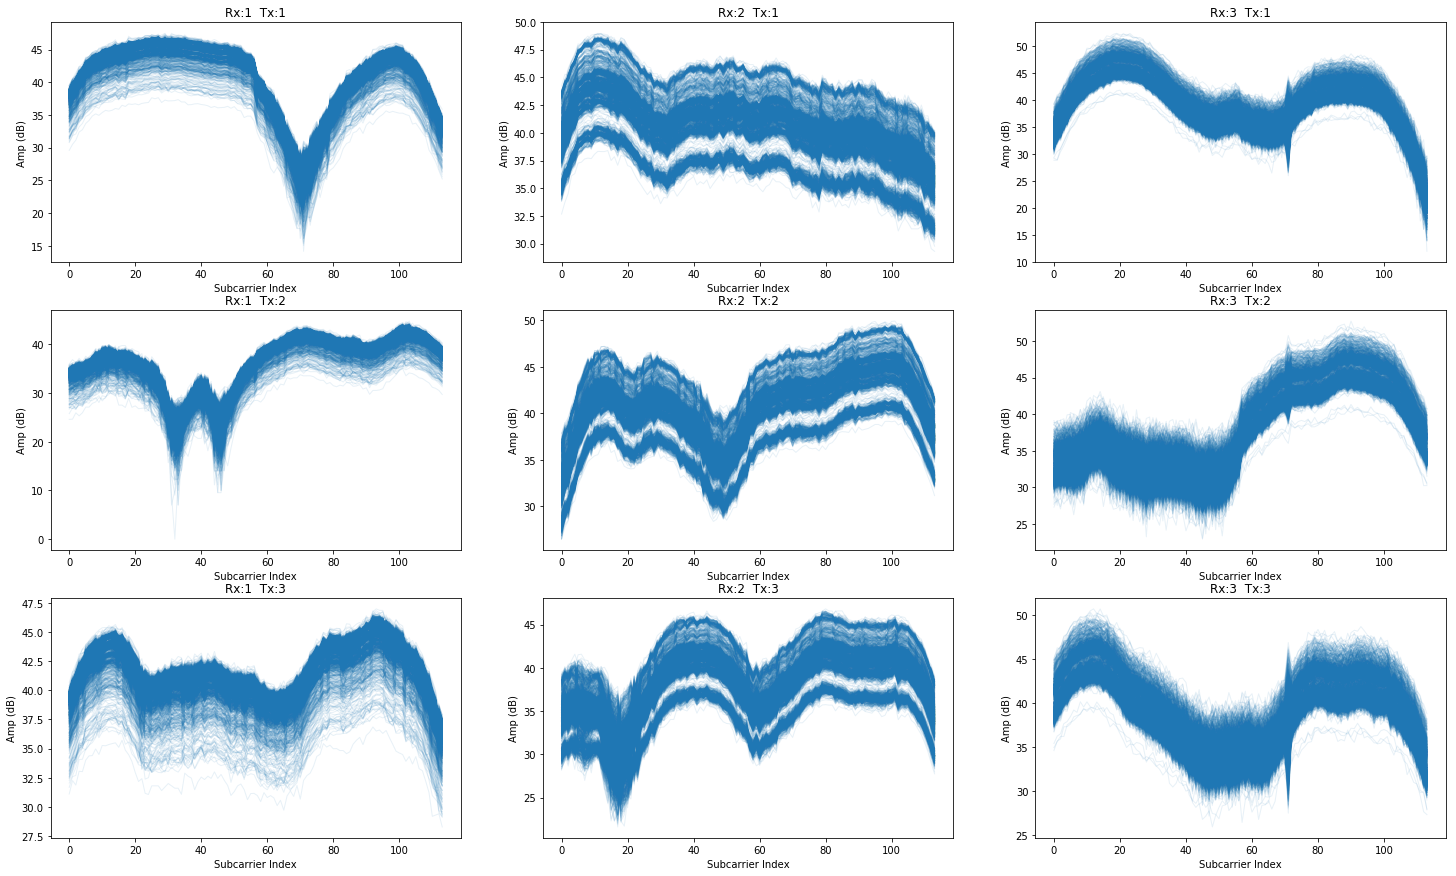

In [7]:
data = get_csi(loadmat("/home/kalvik/Documents/test_157_mat.mat"))
data = np.array(fill_gaps(data))
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(25, 15))
for i in range(3):
    for j in range(3):
        for k in range(0, 1997):
            axs[j, i].set_xlabel('Subcarrier Index')
            axs[j, i].set_ylabel('Amp (dB)')
            axs[j, i].set_title('Rx:{}  Tx:{}'.format(i+1, j+1))
            axs[j, i].plot(db(data[k, i, j, :]), 'C0', alpha=0.1,  linewidth=1)
plt.savefig("../../channel_157.png", bbox_inches='tight', dpi=150)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(data_abs[:6000][0])
plt.show()

In [ ]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data)
print(pca_data.shape)

In [ ]:
np.savetxt("../../data_csi.csv", pca_data, delimiter=",")

In [ ]:
data = get_csi(loadmat("/home/kalvik/Documents/matlab.mat"))

abs_dat = []
for i in range(len(data)):
    abs_dat.append(np.abs(get_scaled_csi(data[i])[0][0][4]))

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(abs_dat[1700:8000])

In [ ]:
abs_dat = []
for i in range(len(data)):
    abs_dat.append(np.abs(get_scaled_csi(data[i])[0][0][0]))
plt.figure(figsize=(25,5))
plt.plot(abs_dat[7000:9000], label='Original CSI')

smooth_data = smooth(abs_dat,21)
plt.plot(smooth_data[7000:9000], label='Denoised CSI')

plt.legend(loc='lower right', prop={'size': 25})
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("denoise.png", bbox_inches='tight', dpi=150)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(np.arange(7000, 9000), abs_dat[7000:9000], label='Original CSI')

plt.legend(loc='lower right', prop={'size': 25})
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("mean_imp.png", bbox_inches='tight', dpi=150)

In [ ]:
amp = np.absolute(get_scaled_csi(data[6]))
mean_amp = np.mean(amp)

amp_temp = []
for i in range(30):
    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
tmp = np.array(amp_temp).flatten()

In [ ]:
mean_amp

In [ ]:
amp_temp = np.array(amp_temp).reshape(-1)

In [ ]:
tmp = []
for i in amp_temp:
    if (not np.isnan(i)):
        tmp.append(np.nan)
    else:
        tmp.append(mean_amp)

In [ ]:
plt.figure(figsize=(25,5))

plt.plot(amp_temp, label='Original CSI')
plt.plot(tmp, label='Mean Imputed CSI')

plt.legend(loc='upper left', prop={'size': 25})
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Sub-carrier index", fontsize= 25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("mean_impute.png", bbox_inches='tight', dpi=150)